In [1]:
import numpy as np
from keras.utils import to_categorical
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
X_train = np.load('X_train_5_clases.npy')
X_test = np.load('X_test_5_clases.npy')
y_train = np.load('y_train_5_clases.npy')
y_test = np.load('y_test_5_clases.npy')

# Paso los datos a one_hot_encoding
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

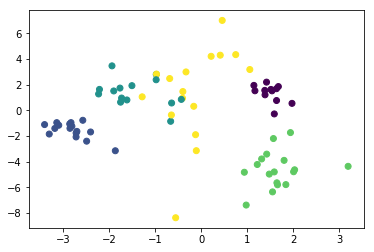

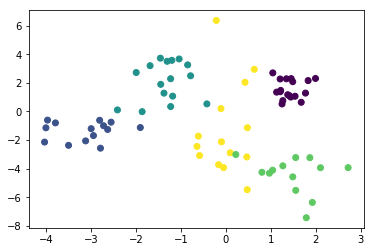

In [3]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.show()

In [4]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers

In [8]:
input_features = 2
lambd = 0
hidden_units = 20
output_size = y_train_cat.shape[1]
model = Sequential()
model.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd)))
model.add(Activation('sigmoid'))
model.add(Dense(output_size))
model.add(Activation('softmax')) # Notar que en vez de sigmoidea es softmax
model.summary()

lr = 0.04 
batch_size = 20
epochs = 1000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy
model.compile(loss = 'categorical_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                60        
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_4 (Activation)    (None, 5)                 0         
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


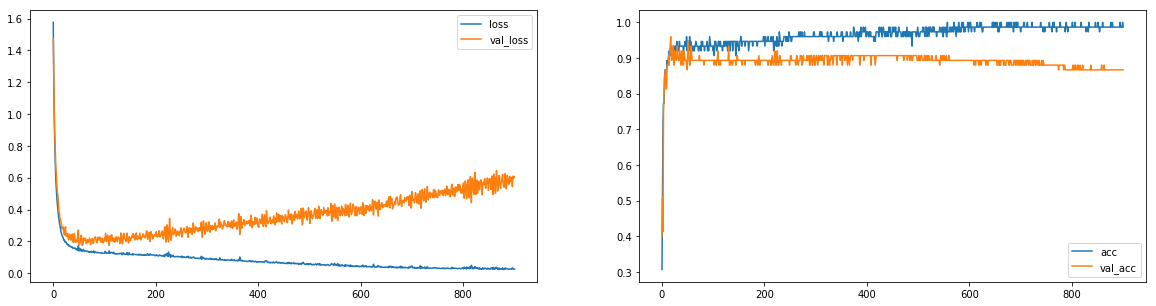

In [6]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses],
         )

43968/46176 [===========================>..] - ETA: 0s

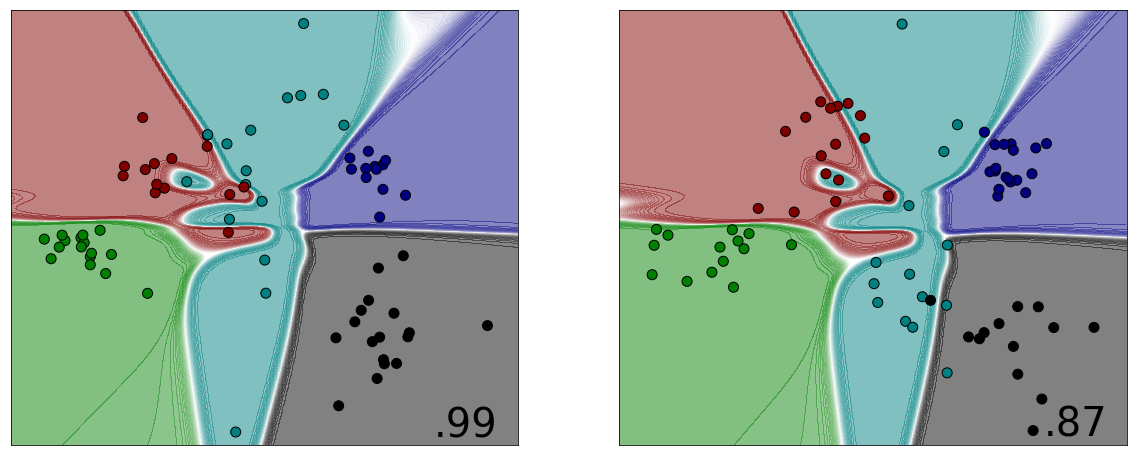

In [7]:
from softmax_helper import plot_boundaries_keras

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model.evaluate(X_train, y_train_cat)
score_test = model.evaluate(X_test, y_test_cat)
Z_aux, Z = plot_boundaries_keras(X_train, y_train, score_train[1], model.predict_proba, h =.05, ax=ax1)
Z_aux, Z = plot_boundaries_keras(X_test, y_test, score_test[1], model.predict_proba, h =.05, ax=ax2)
plt.show()